# Metrics Evaluation Lab

## Part 1

### Importing Dataset

In [5]:
import pandas as pd
mushroom = pd.read_csv('../data/secondary_data_mushrooms.csv', sep=';')
mushroom.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


### Question: How does a KNN model predict if a mushroom is from winter season? 

## Part 2

### Missing Values

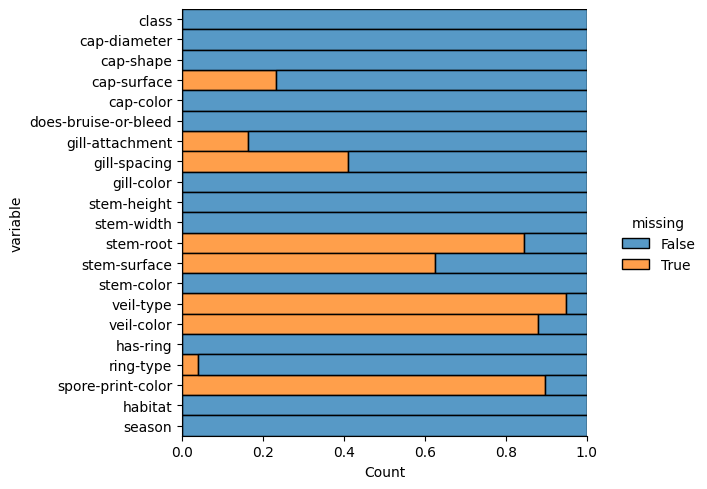

In [6]:
import seaborn as sns

sns.displot(
    data=mushroom.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)

### Dropping Values 

In [7]:
mushroom2 = mushroom.drop(columns=['stem-root', 'stem-surface','veil-type','veil-color','spore-print-color', 'gill-spacing']) # drop object 
mushroom2.dropna(axis = 0, how = 'any', inplace = True)

### Normalize Numeric Values

In [8]:
from sklearn import preprocessing

numeric_cols = mushroom2.select_dtypes(include=['int64', 'float64']).columns

scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(mushroom2[numeric_cols])   # conduct data transformation
scaled_df = pd.DataFrame(d, columns=numeric_cols)  
mushroom2[numeric_cols] = scaled_df  
mushroom2.describe()

,cap-diameter,stem-height,stem-width
count,24357.000000,24357.000000,24357.000000
mean,0.121908,0.244881,0.134454
std,0.110368,0.120044,0.108202
min,0.003883,0.043088,0.010586
25%,0.056311,0.173788,0.064864
50%,0.100971,0.220108,0.111250
75%,0.148058,0.275763,0.166490
max,1.000000,1.000000,1.000000


### Onehot Encode 

In [13]:
mushroom2 = mushroom2.astype({col: 'category' for col in mushroom2.select_dtypes(include='object').columns})
cat_cols = mushroom2.select_dtypes(include='category').columns

encoded = pd.get_dummies(mushroom2[cat_cols])
encoded.head()  

,class_e,class_p,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_o,cap-shape_p,cap-shape_s,cap-shape_x,cap-surface_d,...,habitat_g,habitat_h,habitat_l,habitat_m,habitat_u,habitat_w,season_a,season_s,season_u,season_w
0,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
1,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
2,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
3,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True


In [14]:
mushroom2 = mushroom2.drop(cat_cols, axis=1)
mushroom2 = mushroom2.join(encoded)

In [15]:
mushroom2.dropna(axis = 0, how = 'any', inplace = True)
print(mushroom2.info())

<class 'pandas.core.frame.DataFrame'>
Index: 24357 entries, 0 to 37064
Data columns (total 88 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cap-diameter            24357 non-null  float64
 1   stem-height             24357 non-null  float64
 2   stem-width              24357 non-null  float64
 3   class_e                 24357 non-null  bool   
 4   class_p                 24357 non-null  bool   
 5   cap-shape_b             24357 non-null  bool   
 6   cap-shape_c             24357 non-null  bool   
 7   cap-shape_f             24357 non-null  bool   
 8   cap-shape_o             24357 non-null  bool   
 9   cap-shape_p             24357 non-null  bool   
 10  cap-shape_s             24357 non-null  bool   
 11  cap-shape_x             24357 non-null  bool   
 12  cap-surface_d           24357 non-null  bool   
 13  cap-surface_e           24357 non-null  bool   
 14  cap-surface_g           24357 non-null  boo

### Prevalence of Winter Season

In [45]:
print(mushroom2['season_w'].value_counts()[1] / mushroom2['season_w'].count())

0.09820585457979225


/tmp/ipykernel_3213/1921006264.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(mushroom2['season_w'].value_counts()[1] / mushroom2['season_w'].count())


### Train/Test Split

In [46]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(mushroom2, test_size=0.4, stratify=mushroom2['season_w'], random_state=99)

### Training Classifier

In [47]:
import random
from sklearn.neighbors import KNeighborsClassifier
random.seed(99)  

X_train = train.drop(['season_w'], axis=1).values
y_train = train['season_w'].values

neigh = KNeighborsClassifier(n_neighbors=17)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=17)

### Accuracy Score

In [48]:
X_test = test.drop(['season_w'], axis=1).values
y_test = test['season_w'].values

print(neigh.score(X_test, y_test))

0.9624345684080878


### Confusion Matrix

In [49]:
from sklearn.metrics import accuracy_score

test_probs = neigh.predict_proba(X_test)
test_preds = neigh.predict(X_test)
test_probabilities = pd.DataFrame(test_probs, columns = ['has-ring_f','has-ring_t'])
final_model = pd.DataFrame({'actual_class': y_test.tolist(),
                           'pred_class': test_preds.tolist(),
                           'pred_prob': test_probabilities['has-ring_t']})
final_model.head()

,actual_class,pred_class,pred_prob
0,False,False,0.0
1,False,False,0.0
2,False,False,0.0
3,False,False,0.0
4,False,False,0.0


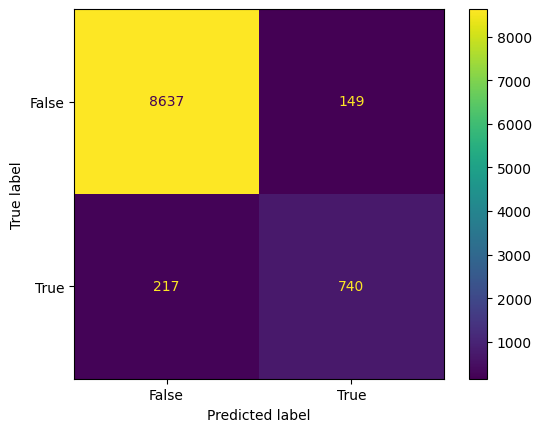

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss

final_model.actual_class = final_model.actual_class.astype('category')
final_model.pred_class = final_model.pred_class.astype('category')

cm = confusion_matrix(final_model.actual_class, final_model.pred_class) 
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)  
disp.plot()

### TPR

In [53]:
tpr = 740 / (740 + 217)
print(tpr)

0.7732497387669801


### FDR

In [54]:
fdr = 149 / (149 + 8637)
print(fdr)

0.01695879808786706


### Cross Entropy 

In [59]:
from sklearn import metrics

mush_prob1 = neigh.predict_proba(X_test) 
mush_pred1 = neigh.predict(X_test)
final_model= pd.DataFrame({'neg_prob':mush_prob1[:, 0], 'pred':mush_pred1,'target':y_test, 'pos_prob':mush_prob1[:, 1]})
print(metrics.log_loss(final_model.target, final_model.pos_prob))

0.08379838261794634


### ROC/AUC

In [60]:
print(metrics.roc_auc_score(final_model.target, final_model.pos_prob))

0.9884835664033762


Text(0.5, 0, 'False Positive Rate')

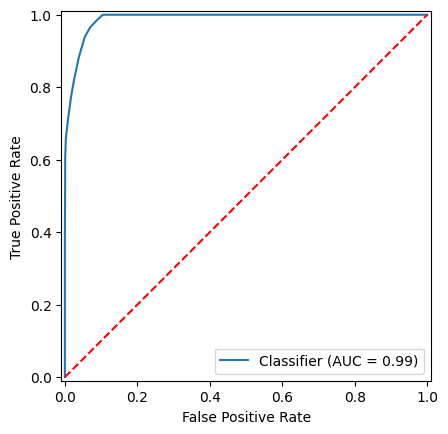

In [63]:
import matplotlib.pyplot as plt
print(metrics.RocCurveDisplay.from_predictions(final_model.target, final_model.pos_prob))
#Set labels and midline...
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

All of these metrics show that the model is fairly accurate. From the accuracy score, a score of 0.96 is close to 1.0. The TPR is 0.77 and FDR is 0.017, meaning the model identifies most of the actual positives and cery few of the predicted positives are false. A cross entropy of 0.083 is fairly low, so the model's predicted possibilities are very close to the actual labels. Finally, a AUC of 0.98 means most of the area under the curve is covered, which again supports the model's accuracy. 

## Part 4